In [1]:
import vamp
import librosa

import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

CHROMATIC_SCALE = 'C C# D D# E F F# G G# A A# B'.split()

In [2]:
audio, sr = librosa.load(
    '/home/thiago.poppe/mestrado/repos/roman-numeral-analysis/resources/songs/Creed - One Last Breath [qnkuBUAwfe0].wav',
    sr=44100,
    duration=15.5
)

ipd.Audio(audio, rate=sr)

## Estimating pitch concert tuning

In [3]:
vamp.collect(audio, sample_rate=sr, plugin_key='nnls-chroma:tuning')

{'list': [{'timestamp':  0.000000000,
   'duration':  15.603809523,
   'label': '440.5 Hz',
   'values': array([440.47845], dtype=float32)}]}

## Estimating chords with Chordino

In [4]:
vamp.collect(audio, sample_rate=sr, plugin_key='nnls-chroma:chordino')

{'list': [{'timestamp':  0.185759637, 'label': 'N'},
  {'timestamp':  0.232199546, 'label': 'D'},
  {'timestamp':  2.043356009, 'label': 'A'},
  {'timestamp':  3.947392290, 'label': 'Bm'},
  {'timestamp':  5.851428571, 'label': 'G'},
  {'timestamp':  7.523265306, 'label': 'D'},
  {'timestamp':  9.520181405, 'label': 'A'},
  {'timestamp':  11.609977324, 'label': 'Bm'},
  {'timestamp':  13.560453514, 'label': 'G'},
  {'timestamp':  15.650249433, 'label': 'N'}]}

## Extracting chroma features

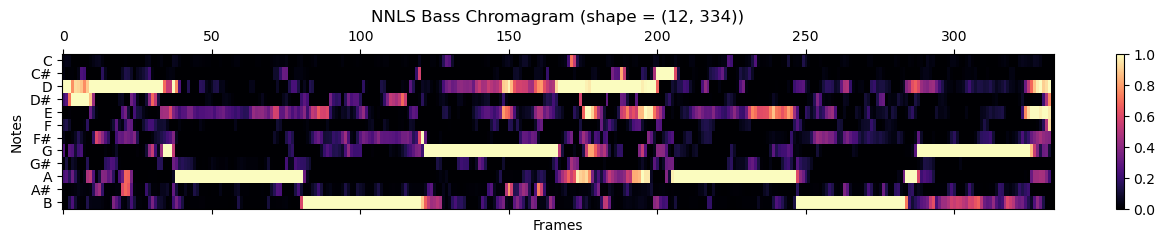

In [5]:
_, bass = vamp.collect(
    audio,
    sample_rate=sr,
    plugin_key='nnls-chroma:nnls-chroma',
    output='basschroma',
    parameters={'chromanormalize': 1}  # min-max normalization
)['matrix']

# For some reason, VAMP is returning the features 3 semitones higher
bass = bass.T
bass = np.roll(bass, shift=-3, axis=0)

plt.matshow(bass, cmap='magma', aspect='auto')
plt.title(f'NNLS Bass Chromagram (shape = {bass.shape})')
plt.xlabel('Frames')
plt.ylabel('Notes')
plt.yticks(range(12), CHROMATIC_SCALE)
plt.colorbar()
plt.show()

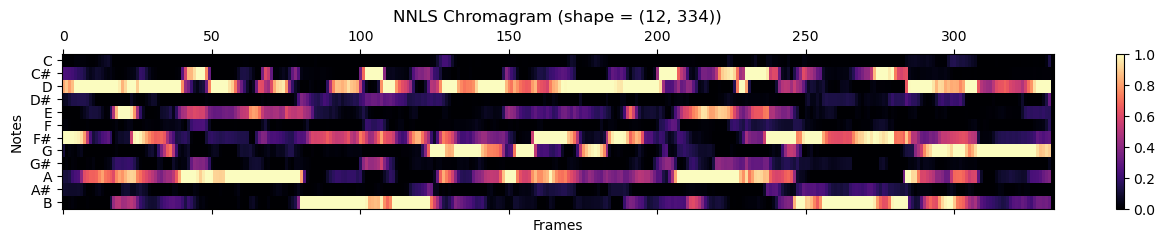

In [6]:
_, chroma = vamp.collect(
    audio,
    sample_rate=sr,
    plugin_key='nnls-chroma:nnls-chroma',
    output='chroma',
    parameters={'chromanormalize': 1}  # min-max normalization
)['matrix']

# For some reason, VAMP is returning the features 3 semitones higher
chroma = chroma.T
chroma = np.roll(chroma, shift=-3, axis=0)

plt.matshow(chroma, cmap='magma', aspect='auto')
plt.title(f'NNLS Chromagram (shape = {chroma.shape})')
plt.xlabel('Frames')
plt.ylabel('Notes')
plt.yticks(range(12), CHROMATIC_SCALE)
plt.colorbar()
plt.show()

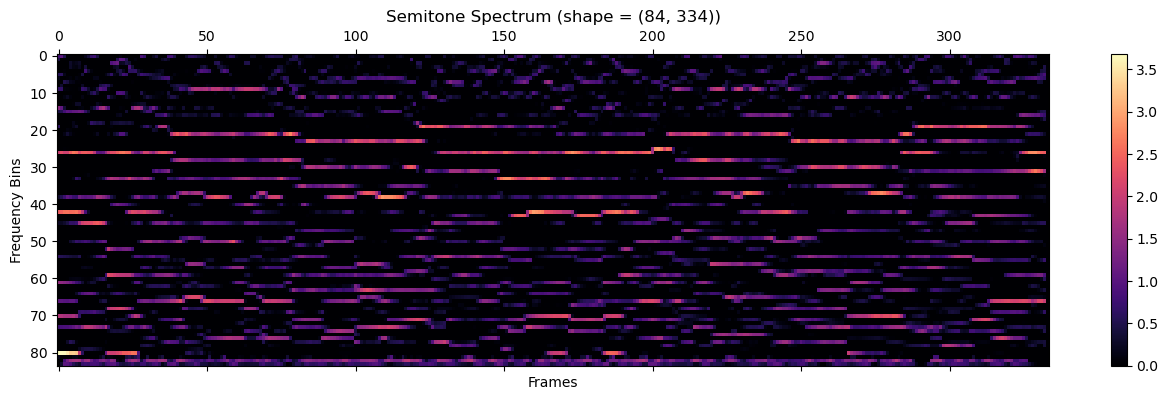

In [7]:
_, spectrum = vamp.collect(
    audio,
    sample_rate=44100,
    plugin_key='nnls-chroma:nnls-chroma',
    output='semitonespectrum'
)['matrix']

# For some reason, VAMP is returning the features 3 semitones higher
spectrum = spectrum.T
spectrum = np.roll(spectrum, shift=-3, axis=0)

plt.matshow(spectrum, cmap='magma', aspect='auto')
plt.title(f'Semitone Spectrum (shape = {spectrum.shape})')
plt.xlabel('Frames')
plt.ylabel('Frequency Bins')
plt.colorbar()
plt.show()

In [8]:
step = 2048 / 44100  # hop size / sample rate
print(f'Approximate duration of song: {step * spectrum.shape[1]:.2f} seconds')

Approximate duration of song: 15.51 seconds


### Resampling features to beat resolution

For this example, we know that we have $8$ bars of $4/4$ yielding $32$ quarter notes, or $256$ $32^{\text{nd}}$ notes.

In [9]:
def minmax(x, axis=0):
    return (x - x.min(axis=axis)) / (x.max(axis=axis) - x.min(axis=axis) + 1e-8)

def standardize(x, axis=0):
    return (x - x.mean(axis=axis)) / (x.std(axis=axis) + 1e-8)

def get_beats_to_frames(num_beats: int, num_frames: int, step: float, sr: int = 44100):   
    beat_to_time_fn = interp1d((0, num_beats), (0, step * num_frames), kind='linear', fill_value='extrapolate')
    time_to_frame_fn = lambda time: librosa.time_to_frames(time, sr=sr, hop_length=2048)
    
    beats_to_frames = time_to_frame_fn(beat_to_time_fn(np.arange(0, num_beats + 1e-4)))
    return beats_to_frames

def resample_feature(feature, beats_to_frames, normalization = None):
    resampled_frames = []
    num_beats = len(beats_to_frames) - 1
    
    for i in range(num_beats):
        if beats_to_frames[i] == beats_to_frames[i+1]:
            frame_idx = min(beats_to_frames[i], feature.shape[1] - 1)
            frame = feature[:, frame_idx]
        else:
            frame = np.mean(feature[:, beats_to_frames[i]:beats_to_frames[i+1]], axis=1)
            
        resampled_frames.append(frame)
        
    resampled_feature = np.stack(resampled_frames, axis=1)
    assert resampled_feature.shape[1] == num_beats
    
    if normalization is not None:
        resampled_feature = normalization(resampled_feature)
    
    return resampled_feature

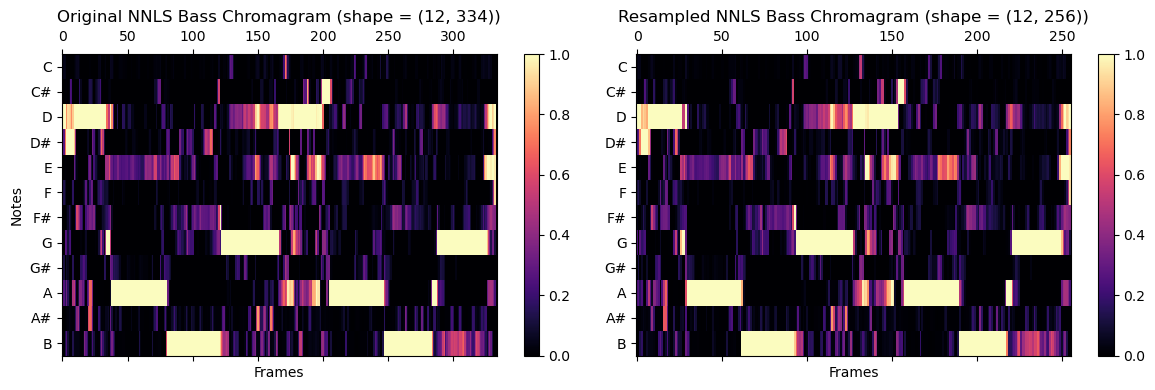

In [10]:
num_beats = 256
num_frames = bass.shape[1]

beats_to_frames = get_beats_to_frames(num_beats, num_frames, step)
resampled_bass = resample_feature(bass, beats_to_frames, normalization=minmax)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

img = axs[0].matshow(bass, cmap='magma', aspect='auto')
axs[0].set_title(f'Original NNLS Bass Chromagram (shape = {bass.shape})')
axs[0].set_xlabel('Frames')
fig.colorbar(img, ax=axs[0])

img = axs[1].matshow(resampled_bass, cmap='magma', aspect='auto')
axs[1].set_title(f'Resampled NNLS Bass Chromagram (shape = {resampled_bass.shape})')
axs[1].set_xlabel('Frames')
fig.colorbar(img, ax=axs[1])

axs[0].set_ylabel('Notes')
axs[0].set_yticks(range(12), CHROMATIC_SCALE)
axs[1].set_yticks(range(12), CHROMATIC_SCALE)

fig.tight_layout()

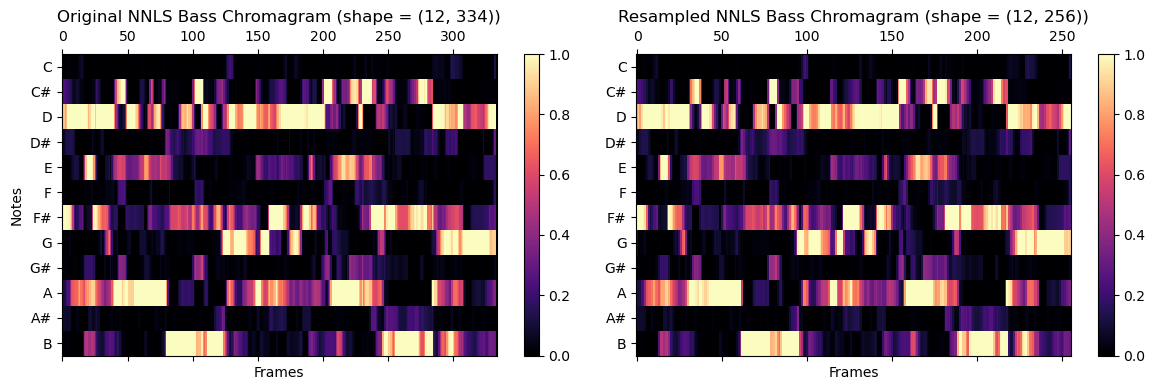

In [11]:
num_beats = 256
num_frames = chroma.shape[1]

beats_to_frames = get_beats_to_frames(num_beats, num_frames, step)
resampled_chroma = resample_feature(chroma, beats_to_frames, normalization=minmax)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

img = axs[0].matshow(chroma, cmap='magma', aspect='auto')
axs[0].set_title(f'Original NNLS Bass Chromagram (shape = {chroma.shape})')
axs[0].set_xlabel('Frames')
fig.colorbar(img, ax=axs[0])

img = axs[1].matshow(resampled_chroma, cmap='magma', aspect='auto')
axs[1].set_title(f'Resampled NNLS Bass Chromagram (shape = {resampled_chroma.shape})')
axs[1].set_xlabel('Frames')
fig.colorbar(img, ax=axs[1])

axs[0].set_ylabel('Notes')
axs[0].set_yticks(range(12), CHROMATIC_SCALE)
axs[1].set_yticks(range(12), CHROMATIC_SCALE)

fig.tight_layout()

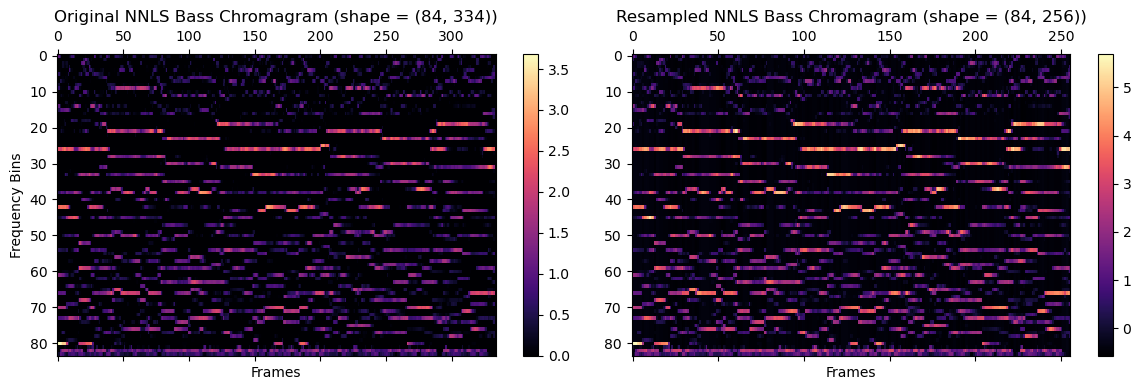

In [12]:
num_beats = 256
num_frames = spectrum.shape[1]

beats_to_frames = get_beats_to_frames(num_beats, num_frames, step)
resampled_spectrum = resample_feature(spectrum, beats_to_frames, normalization=standardize)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

img = axs[0].matshow(spectrum, cmap='magma', aspect='auto')
axs[0].set_title(f'Original NNLS Bass Chromagram (shape = {spectrum.shape})')
axs[0].set_xlabel('Frames')
fig.colorbar(img, ax=axs[0])

img = axs[1].matshow(resampled_spectrum, cmap='magma', aspect='auto')
axs[1].set_title(f'Resampled NNLS Bass Chromagram (shape = {resampled_spectrum.shape})')
axs[1].set_xlabel('Frames')
fig.colorbar(img, ax=axs[1])

axs[0].set_ylabel('Frequency Bins')
fig.tight_layout()

## Comparison with Librosa features

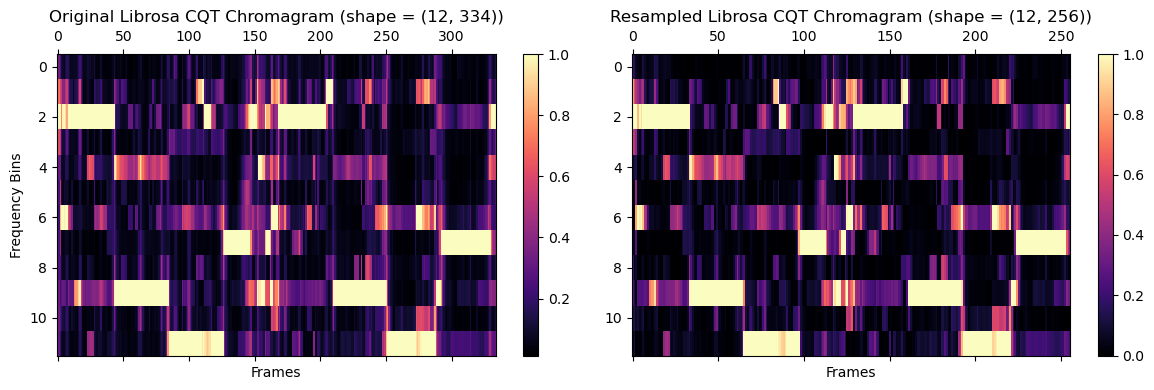

In [13]:
chroma = librosa.feature.chroma_cqt(y=audio, sr=sr, hop_length=2048)
resampled_chroma = resample_feature(chroma, beats_to_frames, normalization=minmax)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

img = axs[0].matshow(chroma, cmap='magma', aspect='auto')
axs[0].set_title(f'Original Librosa CQT Chromagram (shape = {chroma.shape})')
axs[0].set_xlabel('Frames')
fig.colorbar(img, ax=axs[0])

img = axs[1].matshow(resampled_chroma, cmap='magma', aspect='auto')
axs[1].set_title(f'Resampled Librosa CQT Chromagram (shape = {resampled_chroma.shape})')
axs[1].set_xlabel('Frames')
fig.colorbar(img, ax=axs[1])

axs[0].set_ylabel('Frequency Bins')
fig.tight_layout()

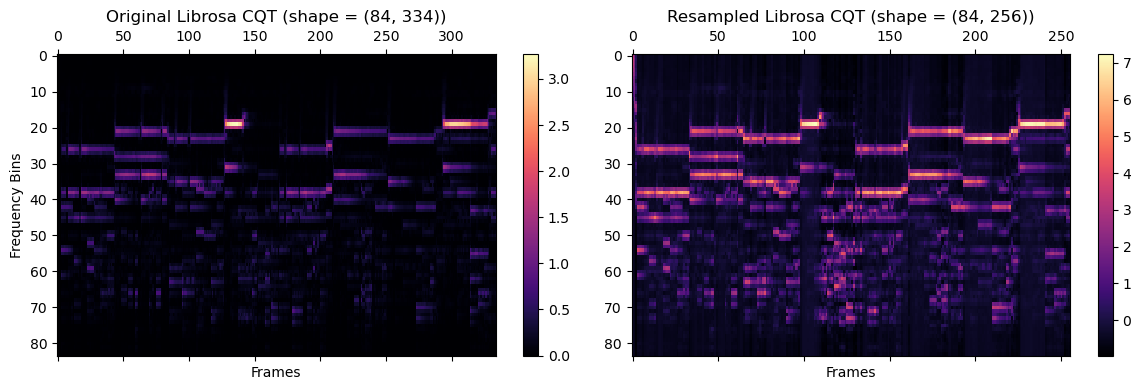

In [14]:
cqt = np.abs(librosa.cqt(y=audio, sr=sr, hop_length=2048))
resampled_cqt = resample_feature(cqt, beats_to_frames, normalization=standardize)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

img = axs[0].matshow(cqt, cmap='magma', aspect='auto')
axs[0].set_title(f'Original Librosa CQT (shape = {cqt.shape})')
axs[0].set_xlabel('Frames')
fig.colorbar(img, ax=axs[0])

img = axs[1].matshow(resampled_cqt, cmap='magma', aspect='auto')
axs[1].set_title(f'Resampled Librosa CQT (shape = {resampled_cqt.shape})')
axs[1].set_xlabel('Frames')
fig.colorbar(img, ax=axs[1])

axs[0].set_ylabel('Frequency Bins')
fig.tight_layout()